TensorFlow Version: 2.19.0

Setting up data generators...
Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.
Found 3360 images for training.
Found 840 images for validation.

Calculating class weights for imbalanced dataset...

Building the CNN architecture...

Configuring callbacks...

Starting model training...


c:\Users\lenovo\Desktop\Tuberculose-CNN\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8291 - auc: 0.8763 - loss: 0.6463 - precision: 0.4879 - recall: 0.7796
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to ..\model\tb_cnn_model_best.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.8295 - auc: 0.8768 - loss: 0.6444 - precision: 0.4889 - recall: 0.7804 - val_accuracy: 0.1667 - val_auc: 0.9261 - val_loss: 2.3844 - val_precision: 0.1667 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9129 - auc: 0.9692 - loss: 0.2535 - precision: 0.6861 - recall: 0.9137
Epoch 2: val_accuracy improved from 0.16667 to 0.29643, saving model to ..\model\tb_cnn_model_best.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.9129 - auc: 0.9692 - loss: 0.2534 - precision: 0.6862 - recall: 0.9137 - val_accuracy: 0.2964 - val_auc: 0.8932 - val_loss: 2.4265 - val_precision: 0.1915 - val_recall: 1.0000 - learning_rate: 1.0000e-04
E

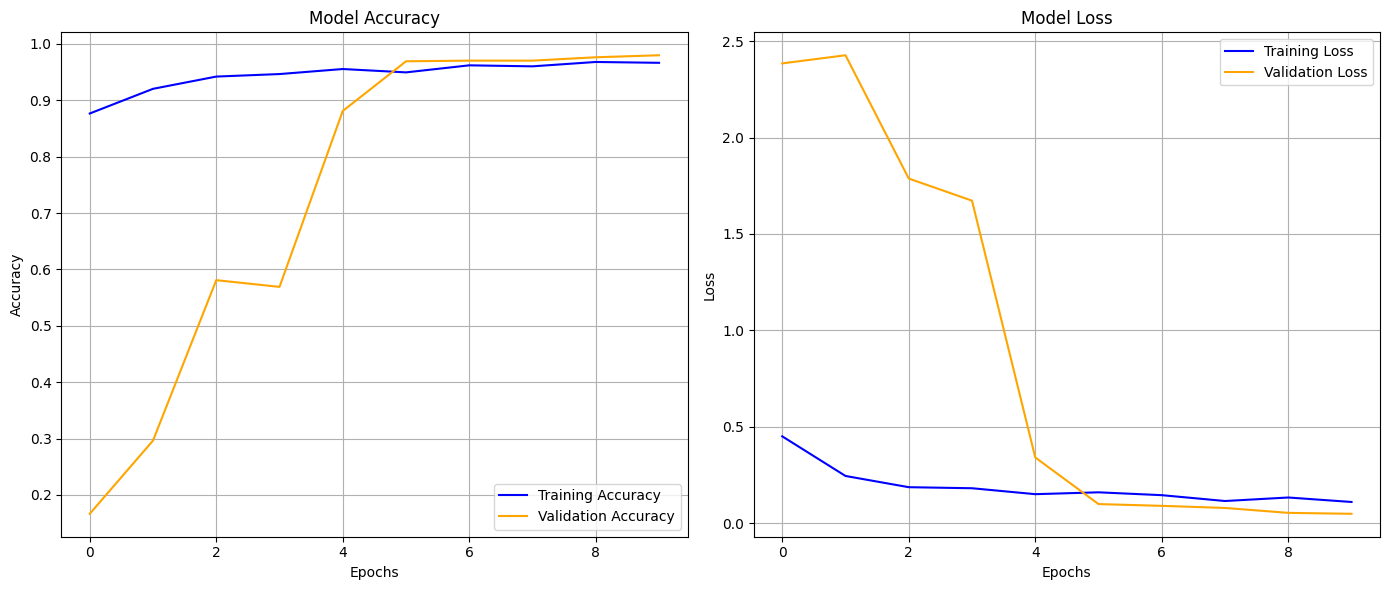

<Figure size 600x600 with 0 Axes>

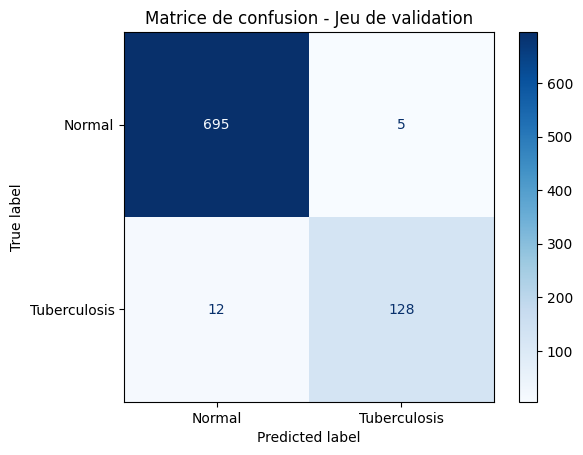


📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99       700
Tuberculosis       0.96      0.91      0.94       140

    accuracy                           0.98       840
   macro avg       0.97      0.95      0.96       840
weighted avg       0.98      0.98      0.98       840



In [ ]:
# ==============================================================================
#                  CNN MODEL TRAINING FOR TUBERCULOSIS DETECTION
# ==============================================================================

# --- 1. Library Imports ---
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(f"TensorFlow Version: {tf.__version__}")

# --- 2. Reproducibility Setup ---
# Fix random seeds to ensure consistent results across runs
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --- 3. Constants and Configuration ---
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
DATA_DIR = os.path.join('..', 'data', 'TB_Chest_Radiography_Database')
MODEL_SAVE_PATH = os.path.join('..', 'model', 'tb_cnn_model_best.keras')

# --- 4. Data Loading and Augmentation ---
print("\nSetting up data generators...")

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation set
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training and validation data
try:
    train_generator = train_datagen.flow_from_directory(
        DATA_DIR,
        subset='training',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True,
        seed=SEED  
    )
    validation_generator = validation_datagen.flow_from_directory(
        DATA_DIR,
        subset='validation',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
except Exception as e:
    print(f"Error loading data: {e}. Cannot proceed with training.")
    raise

print(f"Found {train_generator.samples} images for training.")
print(f"Found {validation_generator.samples} images for validation.")

# --- 5. Calculate Class Weights for Imbalanced Dataset ---
print("\nCalculating class weights for imbalanced dataset...")

train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# --- 6. Model Architecture Definition ---
print("\nBuilding the CNN architecture...")

model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

# --- 7. Callbacks Configuration ---
print("\nConfiguring callbacks...")

os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

# --- 8. Model Training ---
print("\nStarting model training...")

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weight_dict
)

print("\nTraining finished!")

# --- 9. Performance Visualization ---
print("\nPlotting training history (Accuracy and Loss only)...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', color='blue')
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('accuracy_loss_history.png')

print("\nTraining and Plotting completed successfully!")

# --- 10. Model Evaluation ---
print("\nEvaluating the model on the validation set...")

# Predictions on validation set
Y_pred = model.predict(validation_generator)
y_pred = (Y_pred > 0.5).astype(int).ravel()

# True labels
y_true = validation_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Tuberculosis'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Tuberculosis']))